# Malaysian Sign Language (MSL) Classification: Preprocessing Strategy Comparison

Preprocessing Strategy Comparison: `first_30` vs `uniform_30`

## 1. Introduction

In this notebook, we evaluate two preprocessing strategies for Malaysian Sign Language (MSL) classification:

- **first_30**: first 30 valid frames with detected landmarks
    
- **uniform_30**: uniformly sampled 30 valid frames across the video
    

Using a **fixed baseline LSTM model**, we compare both strategies under identical training and evaluation settings to determine which preprocessing method is more effective.


## 2. Setup & Reproducibility

In [1]:
import os
import random
import json
from pathlib import Path

# Evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset


def set_seed(seed: int):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
DATA_DIR = Path(os.getcwd()).parent / "data/BIM Dataset V3"


## 3. Helper Functions (Reusable)

### 3.1. Load Tensors

In [3]:
def load_tensors(tensor_root: Path):
    X_train = np.load(tensor_root / "X_train.npy")
    y_train = np.load(tensor_root / "y_train.npy")
    X_test = np.load(tensor_root / "X_test.npy")
    y_test = np.load(tensor_root / "y_test.npy")

    # Load json label map
    with open(tensor_root / "label_map.json", "r") as f:
        label_map = json.load(f)

    return X_train, y_train, X_test, y_test, label_map

### 3.2. Build DataLoaders

In [4]:
def build_loaders(X_train, y_train, X_test, y_test, batch_size=32):
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size,
        shuffle=True,
    )

    test_loader = DataLoader(
        TensorDataset(X_test_t, y_test_t),
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, test_loader


### 3.3. Plot Training Curves

In [30]:
def plot_loss_and_accuracy(
    train_losses, val_losses, train_accs, val_accs, title_prefix=""
):
    """
    Plot training & validation loss and accuracy side-by-side.

    Parameters
    ----------
    train_losses : list[float]
        Training loss per epoch
    val_losses : list[float]
        Validation loss per epoch
    train_accs : list[float]
        Training accuracy per epoch
    val_accs : list[float]
        Validation accuracy per epoch
    title_prefix : str
        Prefix for plot titles (e.g. 'first_30', 'uniform_30')
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -----------------------
    # Loss curves
    # -----------------------
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Validation Loss")
    axes[0].set_title(f"{title_prefix} Loss Curves")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # -----------------------
    # Accuracy curves
    # -----------------------
    axes[1].plot(train_accs, label="Train Accuracy")
    axes[1].plot(val_accs, label="Validation Accuracy")
    axes[1].set_title(f"{title_prefix} Accuracy Curves")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## 4. Baseline LSTM Model Definition

In [5]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

## 5. Training & Evaluation Utilities

### 5.1. Training Loop

In [27]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=100,
    gradient_clip=False,
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # ======================
        # Training
        # ======================
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()

            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()

            # Optional but recommended for LSTM
            if gradient_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ======================
        # Validation
        # ======================
        model.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for xb, yb in test_loader:
                outputs = model(xb)
                loss = criterion(outputs, yb)

                val_loss_sum += loss.item() * xb.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{epochs}] "
                f"Train Loss: {train_loss:.4f}, "
                f"Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, "
                f"Val Acc: {val_acc:.4f}"
            )

    return train_losses, val_losses, train_accs, val_accs


### 5.2. Evaluation Loop

In [21]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    preds, labels = [], []
    loss_sum, total = 0.0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            loss = criterion(out, yb)
            p = out.argmax(dim=1)

            loss_sum += loss.item() * xb.size(0)
            total += yb.size(0)

            preds.append(p.cpu().numpy())
            labels.append(yb.cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    acc = (preds == labels).mean()
    avg_loss = loss_sum / total
    return avg_loss, acc, preds, labels


## 6. Experiment Runner

In [28]:
def run_experiment(name, tensor_root, epochs=100, gradient_clip=False):
    print(f"\n{'=' * 60}")
    print(f"Running experiment: {name}")
    print(f"{'=' * 60}")

    # ---- load data ----
    X_train, y_train, X_test, y_test, _ = load_tensors(tensor_root)
    train_loader, test_loader = build_loaders(X_train, y_train, X_test, y_test)

    input_size = X_train.shape[-1]
    num_classes = len(np.unique(y_train))

    # ---- model ----
    model = BaselineLSTM(input_size, 64, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # ---- training (NOW RETURNS CURVES) ----
    train_losses, val_losses, train_accs, val_accs = train_model(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        epochs=epochs,
        gradient_clip=gradient_clip,
    )

    # ---- evaluation ----
    test_loss, test_acc, y_pred, y_true = evaluate_model(
        model,
        test_loader,
        criterion,
    )

    print(f"\n{name} — Test Loss: {test_loss:.4f}")
    print(f"{name} — Test Accuracy: {test_acc:.4f}")

    return {
        "name": name,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "y_true": y_true,
        "y_pred": y_pred,
    }


## 7. Run Experiments: `first_30` vs `uniform_30`

In [29]:
BASE = DATA_DIR / "tensors"

results = {}

results["first_30"] = run_experiment(
    "first_30", BASE / "first_30", epochs=100, gradient_clip=True
)
results["uniform_30"] = run_experiment(
    "uniform_30", BASE / "uniform_30", epochs=100, gradient_clip=True
)



Running experiment: first_30
Epoch [10/100] Train Loss: 2.2538, Train Acc: 0.2494, Val Loss: 2.2610, Val Acc: 0.2215
Epoch [20/100] Train Loss: 1.7742, Train Acc: 0.3285, Val Loss: 1.8746, Val Acc: 0.3385
Epoch [30/100] Train Loss: 1.5376, Train Acc: 0.4299, Val Loss: 1.6067, Val Acc: 0.4462
Epoch [40/100] Train Loss: 1.2589, Train Acc: 0.5228, Val Loss: 1.2749, Val Acc: 0.5323
Epoch [50/100] Train Loss: 1.1524, Train Acc: 0.5831, Val Loss: 1.2915, Val Acc: 0.5323
Epoch [60/100] Train Loss: 0.8478, Train Acc: 0.6769, Val Loss: 1.1657, Val Acc: 0.6308
Epoch [70/100] Train Loss: 0.7727, Train Acc: 0.7112, Val Loss: 0.9031, Val Acc: 0.7015
Epoch [80/100] Train Loss: 0.6042, Train Acc: 0.7790, Val Loss: 0.9796, Val Acc: 0.7169
Epoch [90/100] Train Loss: 0.5061, Train Acc: 0.8308, Val Loss: 0.9727, Val Acc: 0.7323
Epoch [100/100] Train Loss: 0.4275, Train Acc: 0.8496, Val Loss: 0.9803, Val Acc: 0.7631

first_30 — Test Loss: 0.9803
first_30 — Test Accuracy: 0.7631

Running experiment: unifo

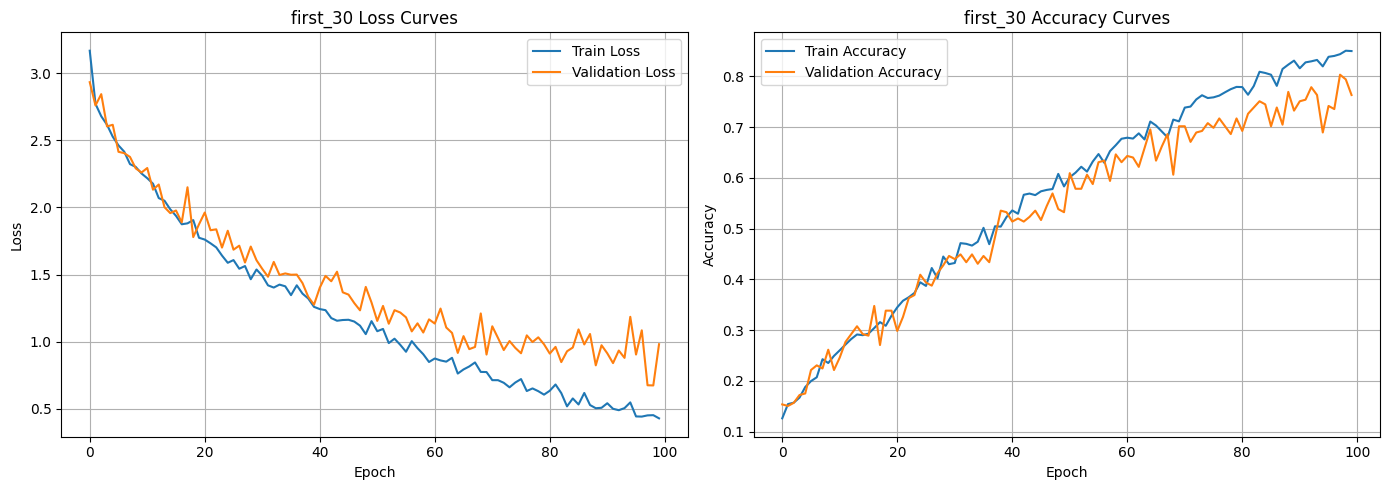

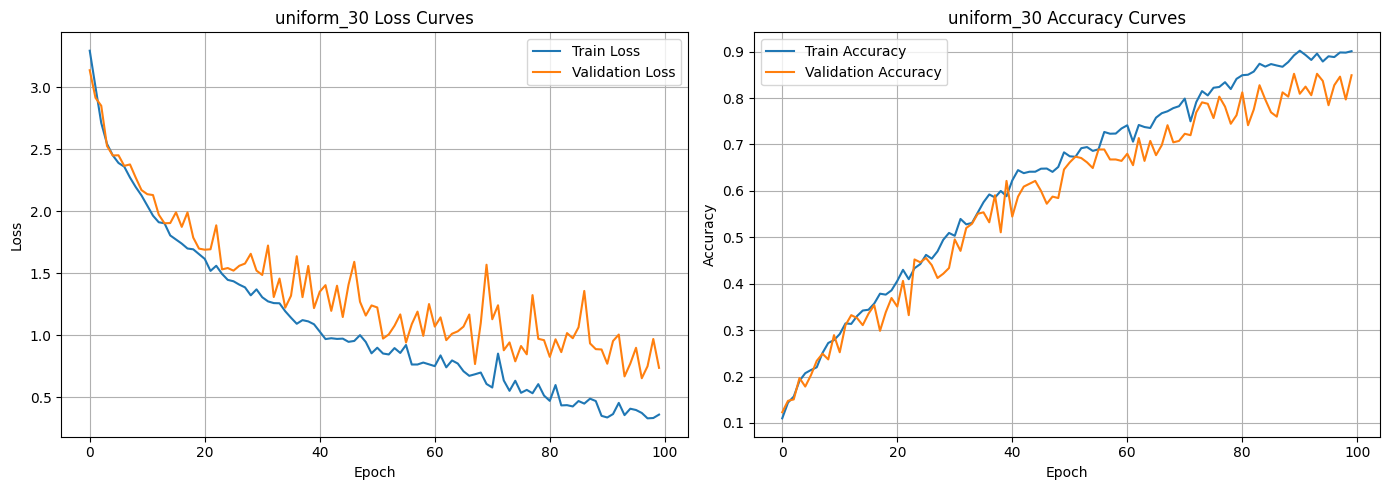

In [31]:
plot_loss_and_accuracy(
    results["first_30"]["train_losses"],
    results["first_30"]["val_losses"],
    results["first_30"]["train_accs"],
    results["first_30"]["val_accs"],
    title_prefix="first_30",
)
plot_loss_and_accuracy(
    results["uniform_30"]["train_losses"],
    results["uniform_30"]["val_losses"],
    results["uniform_30"]["train_accs"],
    results["uniform_30"]["val_accs"],
    title_prefix="uniform_30",
)

## 8. Results Summary & Decision

In [32]:
summary = pd.DataFrame(
    [
        {
            "Preprocessing": r["name"],
            "Test Accuracy": r["test_accuracy"],
            "Test Loss": r["test_loss"],
        }
        for r in results.values()
    ]
)

In [33]:
best = summary.sort_values("Test Accuracy", ascending=False).iloc[0]

print("\nBest preprocessing method:")
print(best)



Best preprocessing method:
Preprocessing    uniform_30
Test Accuracy      0.849231
Test Loss          0.739102
Name: 1, dtype: object


## 9. Confusion Matrix with Best Preprocessing Strategy

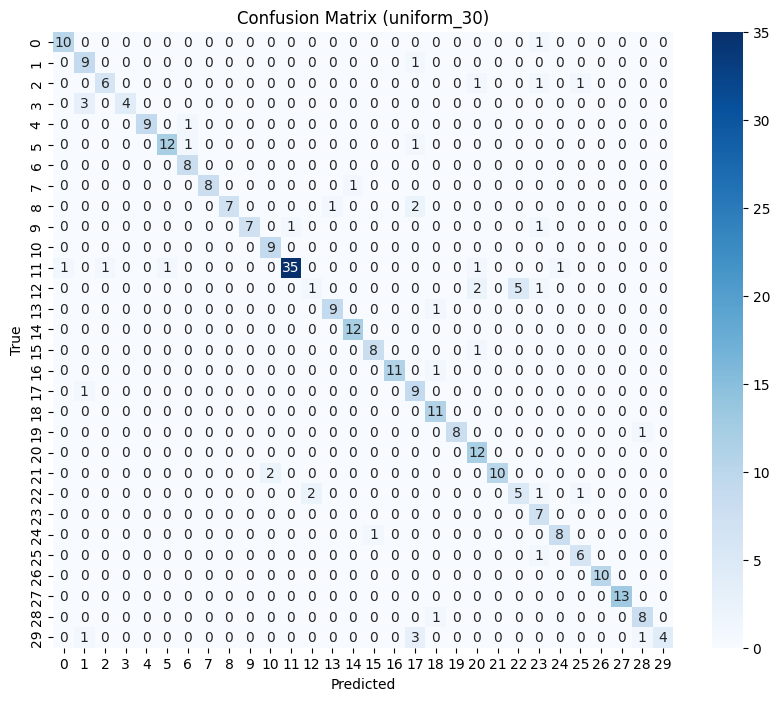

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.64      0.90      0.75        10
           2       0.86      0.67      0.75         9
           3       1.00      0.57      0.73         7
           4       1.00      0.90      0.95        10
           5       0.92      0.86      0.89        14
           6       0.80      1.00      0.89         8
           7       1.00      0.89      0.94         9
           8       1.00      0.70      0.82        10
           9       1.00      0.78      0.88         9
          10       0.82      1.00      0.90         9
          11       0.97      0.88      0.92        40
          12       0.33      0.11      0.17         9
          13       0.90      0.90      0.90        10
          14       0.92      1.00      0.96        12
          15       0.89      0.89      0.89         9
          16       1.00      0.92      0.96        12
          17       0.56    

In [35]:
best_result = next(r for r in results.values() if r["name"] == best["Preprocessing"])

conf = confusion_matrix(
    best_result["y_true"],
    best_result["y_pred"],
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf, cmap="Blues", annot=True, fmt="d")
plt.title(f"Confusion Matrix ({best['Preprocessing']})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(
    classification_report(
        best_result["y_true"],
        best_result["y_pred"],
    )
)
